#### Data Preprocessing and Analysis

In [1]:
import pandas as pd

df = pd.read_csv("../data/rain.csv")

station_to_city = {
    "新北": "新北市",
    "淡水": "新北市",
    "鞍部": "臺北市",
    "臺北": "臺北市",
    "竹子湖": "臺北市",
    "基隆": "基隆縣",
    "彭佳嶼": "基隆縣",
    "花蓮": "花蓮縣",
    "新屋": "桃園市",
    "宜蘭": "宜蘭縣",
    "金門": "金門縣",
    "田中": "彰化縣",
    "後龍": "苗栗縣",
    "古坑": "雲林縣",
    "東吉島": "澎湖縣",
    "澎湖": "澎湖縣",
    "臺南": "臺南市",
    "永康": "臺南市",
    "高雄": "高雄市",
    "嘉義": "嘉義縣",
    "臺中": "臺中市",
    "阿里山": "嘉義縣",
    "大武": "臺東縣",
    "玉山": "南投縣",
    "新竹": "新竹縣",
    "恆春": "屏東縣",
    "成功": "臺東縣",
    "蘭嶼": "臺東縣",
    "日月潭": "南投縣",
    "臺東": "臺東縣",
    "馬祖": "連江縣",
    "中壢": "桃園市",
    "梧棲": "臺中市",
    "員林": "彰化縣",
    "斗六": "雲林縣",
    "蘇澳": "宜蘭縣",
    "公館": "苗栗縣",
    "屏東": "屏東縣",
}

df["city"] = df["station_name"].map(station_to_city)
missing = df[df["city"].isna()]["station_name"].unique()
print("尚未對應的測站：", missing)

尚未對應的測站： []


In [2]:
df = df.drop(columns=["station_id"])
df = df[["city", "station_name", "station_name_en", "date", "precip_mm"]]

In [3]:
print(df.sample(10))

      city station_name station_name_en        date  precip_mm
10288  臺中市           梧棲            WUQI  2025-07-28       69.0
1044   臺北市           臺北          TAIPEI  2025-04-10       38.5
6296   嘉義縣           嘉義          CHIAYI  2025-11-08        0.1
6877   嘉義縣          阿里山         ALISHAN  2025-09-20        5.0
11840  屏東縣           屏東        Pingdong  2025-07-05        0.5
10265  臺中市           梧棲            WUQI  2025-07-05       49.0
6883   嘉義縣          阿里山         ALISHAN  2025-09-26        2.0
11476  苗栗縣           公館        Gongguan  2025-05-17        0.0
4502   澎湖縣          東吉島       DONGJIDAO  2025-04-03        0.0
692    臺北市           鞍部            ANBU  2025-03-04       63.0


Some cities have `std_r` equal to NaN because that city only has one weather station.  
The std() function requires at least two values (n ≥ 2) to calculate variability.  
If there is only one value, variation cannot be computed, so `std_r` becomes NaN.

In [4]:
import pandas as pd

df["date"] = pd.to_datetime(df["date"])

city_rain = (
    df.groupby(["city", "date"], as_index=False).agg(
        station_count=("station_name", "nunique"),  # 計算測站數
        mean_r = ("precip_mm", "mean"),
        max_r = ("precip_mm", "max"),
        std_r = ("precip_mm", "std")
    )
)
print(city_rain.sample(10))

     city       date  station_count  mean_r  max_r      std_r
3589  臺北市 2025-05-05              3   0.200    0.5   0.264575
3292  臺中市 2025-05-23              2   0.000    0.0   0.000000
3918  臺南市 2025-05-19              2   0.000    0.0   0.000000
4771  苗栗縣 2025-02-16              2   0.000    0.0   0.000000
5654  金門縣 2025-10-27              1   1.500    1.5        NaN
1956  新北市 2025-03-08              2   0.550    1.0   0.636396
2646  桃園市 2025-05-07              2  58.500   62.5   5.656854
2004  新北市 2025-04-25              2  11.500   12.0   0.707107
4334  臺東縣 2025-08-28              4   1.525    5.0   2.359908
2906  澎湖縣 2025-03-13              2  17.000   30.0  18.384776


`station_count` indicates how many weather stations reported rainfall for each city on a given day.

In [5]:
city_rain["std_r"] = city_rain.apply(
    lambda x: 0 if x["station_count"] == 1 else x["std_r"], axis=1
)

In [6]:
coverage = (
    city_rain.groupby("city")["station_count"]
    .mean()
    .sort_values(ascending=False)
)
print(coverage)


city
臺東縣    4.0
臺北市    3.0
南投縣    2.0
嘉義縣    2.0
宜蘭縣    2.0
基隆縣    2.0
新北市    2.0
屏東縣    2.0
澎湖縣    2.0
桃園市    2.0
臺中市    2.0
彰化縣    2.0
苗栗縣    2.0
臺南市    2.0
雲林縣    2.0
新竹縣    1.0
花蓮縣    1.0
連江縣    1.0
金門縣    1.0
高雄市    1.0
Name: station_count, dtype: float64


Since anomaly detection models require **numeric** input for all features,  
any missing values (NaN) must be handled.

In [7]:
city_rain["std_r"] = city_rain["std_r"].fillna(0)
print(city_rain.sample(10))

     city       date  station_count  mean_r  max_r      std_r
4918  苗栗縣 2025-07-13              2   0.000    0.0   0.000000
2769  桃園市 2025-09-07              2  17.300   34.5  24.324473
4253  臺東縣 2025-06-08              4   7.000   14.0   5.944185
1646  彰化縣 2025-03-13              2  32.000   32.5   0.707107
6123  高雄市 2025-05-19              1   0.000    0.0   0.000000
2562  桃園市 2025-02-12              2  18.750   20.5   2.474874
4172  臺東縣 2025-03-19              4   0.775    2.0   0.932291
4782  苗栗縣 2025-02-27              2   0.000    0.0   0.000000
5306  連江縣 2025-09-24              1   1.500    1.5   0.000000
2475  新竹縣 2025-09-28              1   0.000    0.0   0.000000


🔁 Rolling Feature Example: `rain_3d_sum`

The following table demonstrates how the 3-day accumulated rainfall is computed:

| Date | mean_r | rain_3d_sum | Explanation |
|------|--------|--------------|-------------|
| 1/1  | 2      | 2            |             |
| 1/2  | 3      | 5            |             |
| 1/3  | 1      | 6            |             |
| 1/4  | 0      | 4            | ← sum of (1/4 + 1/3 + 1/2) |

This feature helps the model understand **short-term rainfall accumulation**.


In [8]:
city_rain = city_rain.sort_values(["city", "date"])

city_rain["rain_3d_sum"] = (
    city_rain.groupby("city")["mean_r"]
    .rolling(3, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)
city_rain["rain_7d_sum"] = (
    city_rain.groupby("city")["mean_r"]
    .rolling(7, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)
city_rain["rain_diff"] = ( #今天和昨天的雨量比較
    city_rain.groupby("city")["mean_r"].diff()
)

#### Scaling 📈 Why Use Z-score?

Different cities in Taiwan have very different baseline rainfall levels. For example:

- Keelung naturally receives heavy rainfall throughout the year  
- Taitung may experience very little rainfall in comparison  

Z-score standardization allows each city to be evaluated **fairly**, by measuring how far a given day deviates from its own historical average.

This ensures that the model is not biased by geographic rainfall patterns,  
but instead focuses on whether **a particular day's rainfall is unusual relative to that city's norm**.


In [9]:
city_rain["zscore"] = (
    city_rain.groupby("city")["mean_r"]
    .transform(lambda x: (x - x.mean()) / x.std())
)
#設定極端氣候閥值
city_rain["is_extreme"] = city_rain["zscore"].apply(
    lambda x: 1 if x > 2.5 else 0
)

c:\Users\iclab\anaconda3\envs\water\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\iclab\anaconda3\envs\water\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\iclab\anaconda3\envs\water\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


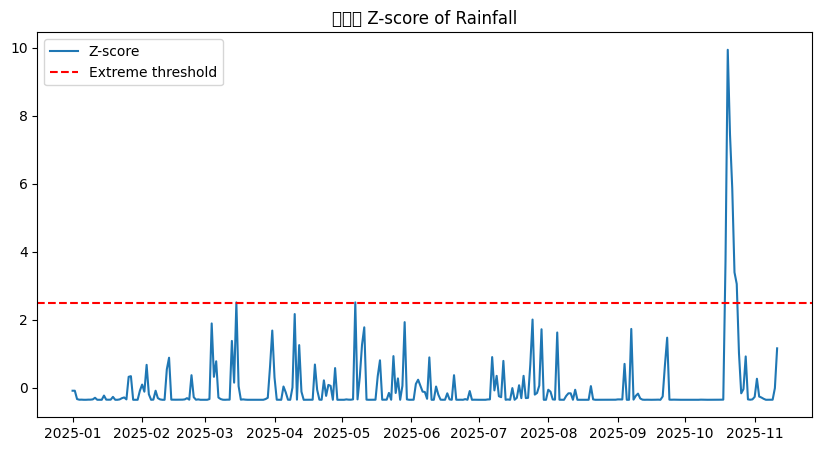

In [10]:
#做個圖表測試
import matplotlib.pyplot as plt

sample_city = "新北市"
subset = city_rain[city_rain["city"] == sample_city]

plt.figure(figsize=(10,5))
plt.plot(subset["date"], subset["zscore"], label="Z-score")
plt.axhline(2.5, color="r", linestyle="--", label="Extreme threshold")
plt.legend()
plt.title(f"{sample_city} Z-score of Rainfall")
plt.show()


In [11]:
#初步分析：哪個縣市極端事件最多？
extreme_city = (
    city_rain.groupby("city")["is_extreme"]
    .sum()
    .sort_values(ascending=False)
)
print(extreme_city.head(10))


city
桃園市    14
基隆縣    12
連江縣    12
屏東縣    11
臺東縣    10
雲林縣    10
新竹縣    10
南投縣     9
彰化縣     9
嘉義縣     9
Name: is_extreme, dtype: int64


In [12]:
print(city_rain.sample(15))

     city       date  station_count  mean_r  max_r      std_r  rain_3d_sum  \
3285  臺中市 2025-05-16              2    0.00    0.0   0.000000         0.00   
5227  連江縣 2025-07-07              1   18.00   18.0   0.000000        18.20   
2501  新竹縣 2025-10-24              1    5.50    5.5   0.000000        68.00   
5716  雲林縣 2025-02-16              2    0.00    0.0   0.000000         0.50   
5052  連江縣 2025-01-13              1    0.00    0.0   0.000000         0.00   
2709  桃園市 2025-07-09              2   95.75  124.5  40.658640       146.75   
5452  金門縣 2025-04-08              1    0.00    0.0   0.000000         0.00   
1157  宜蘭縣 2025-08-01              2    1.00    2.0   1.414214         1.00   
1900  新北市 2025-01-11              2    1.55    3.0   2.050610         1.95   
1663  彰化縣 2025-03-30              2    1.25    1.5   0.353553         1.30   
421   嘉義縣 2025-04-17              2    0.00    0.0   0.000000         0.00   
5349  連江縣 2025-11-06              1    0.00    0.0   0.000000   

`is_extreme` is **not** included in `feature_cols` because it is a manually labeled field.  
Using it during model training would cause **data leakage**, allowing the model to “cheat” by seeing information it should not have.  
Therefore, it is excluded from the training features.


In [13]:
from sklearn.preprocessing import StandardScaler

# 選擇要訓練的特徵欄位
feature_cols = ["mean_r", "max_r", "std_r", "rain_3d_sum", "rain_7d_sum", "rain_diff", "zscore"]

X = city_rain[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### 🤖 AI Model: Isolation Forest for Extreme Rainfall Detection 
To identify potential extreme rainfall events across Taiwan, this project adopts the **Isolation Forest**, a widely-used unsupervised anomaly detection algorithm.


In [14]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=200,       # 樹的數量
    contamination=0.01,    # (汙染率) 其實只是一個「猜測」，你告訴模型：「我猜數據裡有 3% 是異常的」
    max_samples=256,        #建立每棵樹時，要隨機抽取多少個樣本
    max_features=0.5,     #建立每棵樹時，要隨機抽取多少個特徵 (columns)
    n_jobs=-1,       
    random_state=42,
)
model.fit(X_scaled)

# 預測結果
city_rain["anomaly_pred"] = model.predict(X_scaled)
# 顯示原始數據
city_rain["anomaly_score"] = model.decision_function(X_scaled)


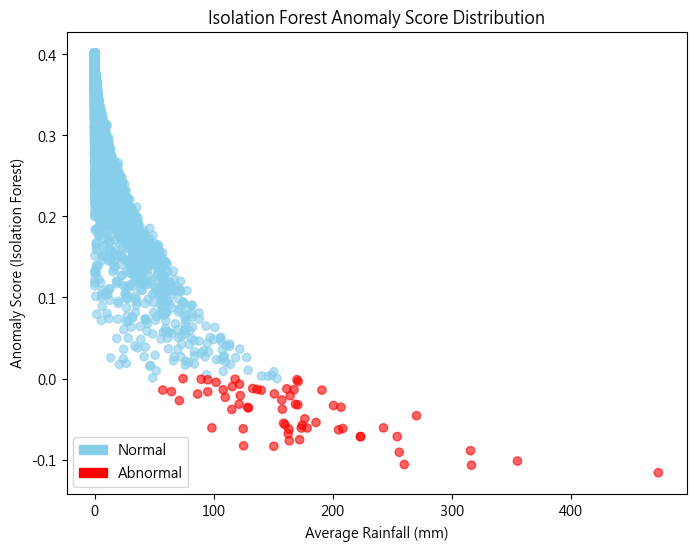

In [15]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,6))

plt.scatter(
    city_rain["mean_r"],
    city_rain["anomaly_score"],
    c=city_rain["anomaly_pred"].map({1: "skyblue", -1: "red"}),
    alpha=0.6,
)

import matplotlib.patches as mpatches
normal_patch = mpatches.Patch(color='skyblue', label='Normal')
abnormal_patch = mpatches.Patch(color='red', label='Abnormal')

plt.legend(handles=[normal_patch, abnormal_patch], loc="lower left")
plt.xlabel("Average Rainfall (mm)")
plt.ylabel("Anomaly Score (Isolation Forest)")
plt.title("Isolation Forest Anomaly Score Distribution")
plt.show()

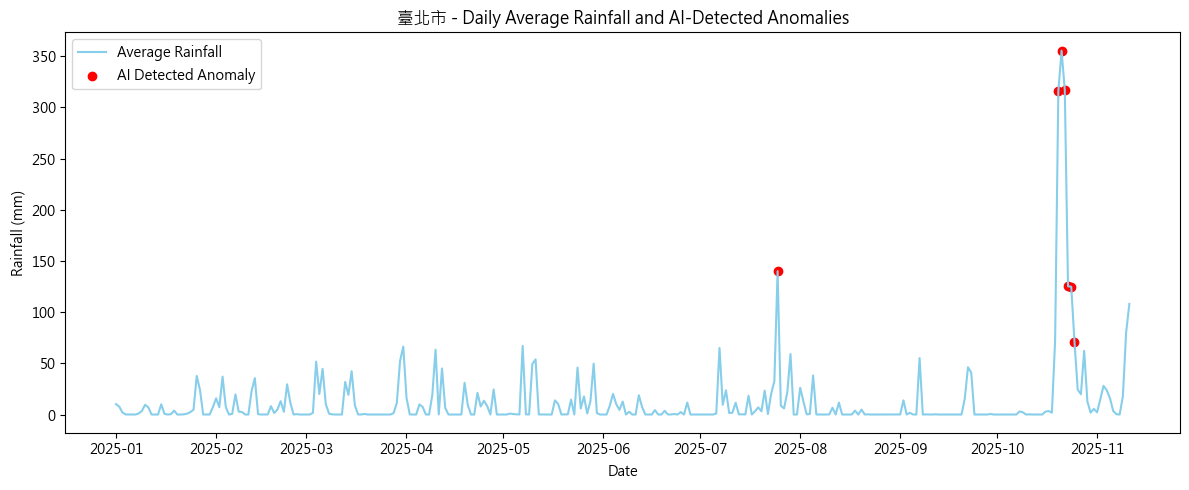

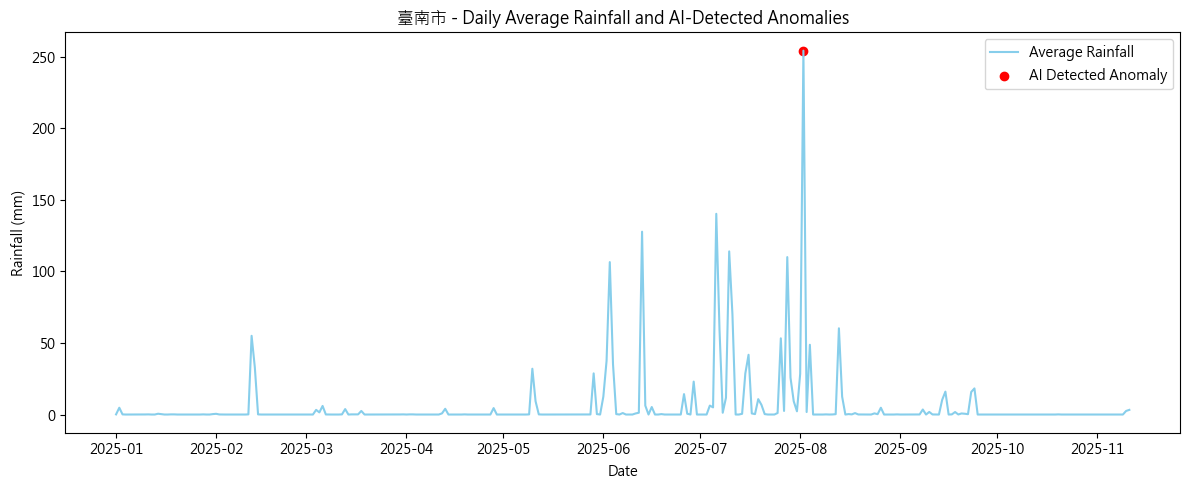

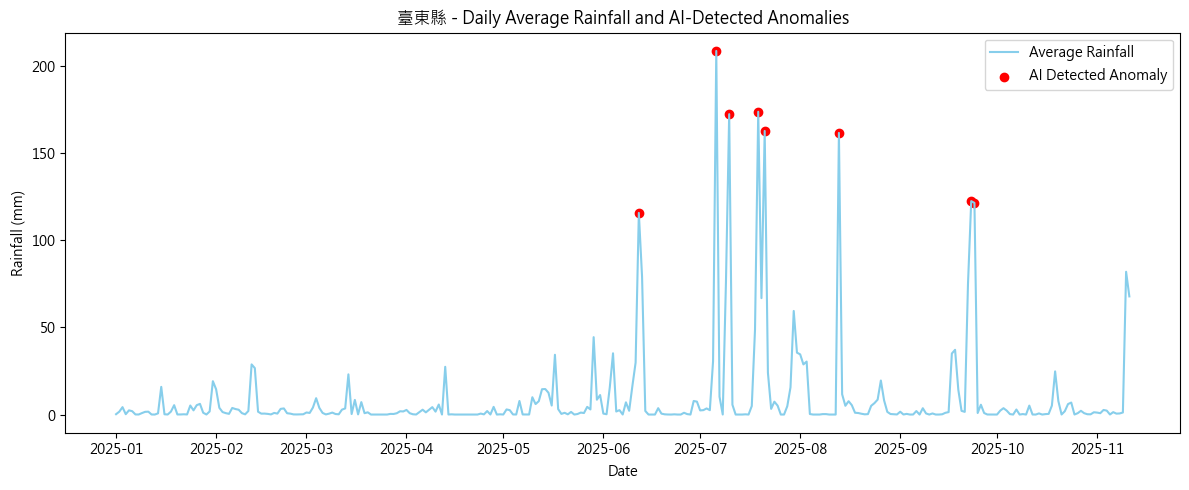

In [16]:
def plot_city_anomalies(city):
    subset = city_rain[city_rain["city"] == city]
    plt.figure(figsize=(12,5))
    plt.plot(subset["date"], subset["mean_r"], label="Average Rainfall", color="skyblue")
    plt.scatter(
        subset.loc[subset["anomaly_pred"] == -1, "date"],
        subset.loc[subset["anomaly_pred"] == -1, "mean_r"],
        color="red", label="AI Detected Anomaly"
    )
    plt.title(f"{city} - Daily Average Rainfall and AI-Detected Anomalies")
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: plot three cities
for city in ["臺北市", "臺南市", "臺東縣"]:
    plot_city_anomalies(city)

In [17]:
city_rain["is_anomaly"] = city_rain["anomaly_pred"].apply(lambda x: 1 if x == -1 else 0)


In [18]:
extreme_summary = (
    city_rain.groupby("city")["is_anomaly"]
    .sum()
    .sort_values(ascending=False)
)

print(extreme_summary)


city
屏東縣    10
臺東縣     8
嘉義縣     7
臺北市     7
新北市     5
南投縣     4
宜蘭縣     4
臺中市     3
雲林縣     3
彰化縣     3
高雄市     2
金門縣     2
基隆縣     1
苗栗縣     1
新竹縣     1
花蓮縣     1
臺南市     1
澎湖縣     0
桃園市     0
連江縣     0
Name: is_anomaly, dtype: int64


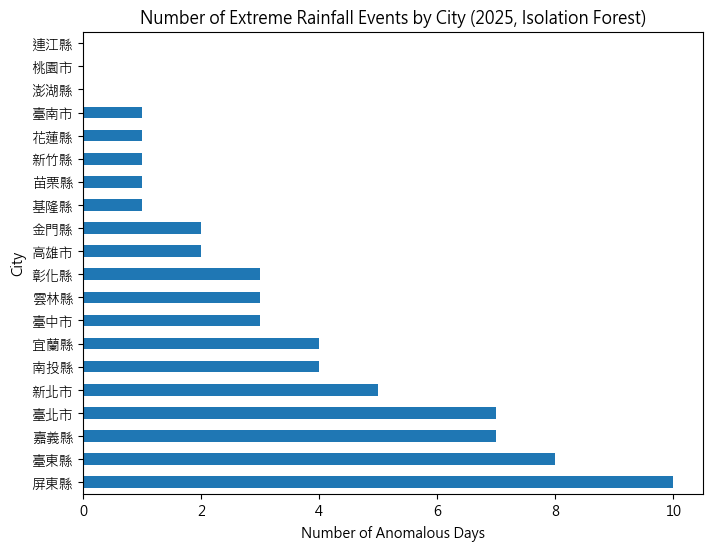

In [19]:
import matplotlib.pyplot as plt

extreme_summary.plot(kind="barh", figsize=(8,6))
plt.title("Number of Extreme Rainfall Events by City (2025, Isolation Forest)")
plt.xlabel("Number of Anomalous Days")
plt.ylabel("City")
plt.show()